# Investigation of the average song length and valence over time due to the rising popularity of music streaming services
### Data Literacy
#### University of Tübingen, Winter Term 2021/22
&copy; 2021 Tobias Ziefle & Johannes Gaus

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy
from tueplots import bundles
plt.rcParams.update(bundles.neurips2021(usetex=False))


The dataset we used is from https://www.kaggle.com/rodolfofigueroa/spotify-12m-songs

In [2]:
df_spotify = pd.read_csv('tracks_features.csv')

## Some interesting plotting:

In [3]:
duration_year =  df_spotify[['name','year', 'duration_ms', 'valence']]

In [4]:
duration_year = duration_year.sort_values(by="year")
duration_year['duration_min'] = (duration_year['duration_ms']/60000).round(2) # to get the song length in minutes
duration_year_filtered = duration_year[duration_year['year'] >= 1975]


#### Release year in years and song length in min:

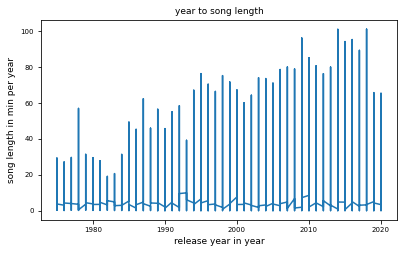

In [5]:
plt.plot(duration_year_filtered["year"], duration_year_filtered["duration_min"])
plt.title("year to song length")
plt.xlabel("release year in year")
plt.ylabel("song length in min per year")
plt.show()

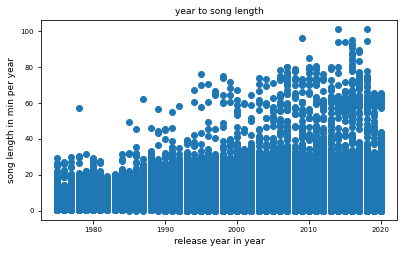

In [6]:
plt.scatter(duration_year_filtered["year"], duration_year_filtered["duration_min"])
plt.title("year to song length")
plt.xlabel("release year in year")
plt.ylabel("song length in min per year")
plt.show()

#### Average song length in min and release year in years:

In [7]:
songs_years = duration_year_filtered[['duration_min','year']].groupby('year', as_index=False).count()
total_length_year = duration_year_filtered[['duration_min','year']].groupby('year', as_index=False).sum()
avg_songlength_per_year = total_length_year['duration_min']/songs_years['duration_min']
avg_songlength_per_year = avg_songlength_per_year.to_frame()
avg_songlength_per_year.insert(loc=0, column='year', value=total_length_year['year'])

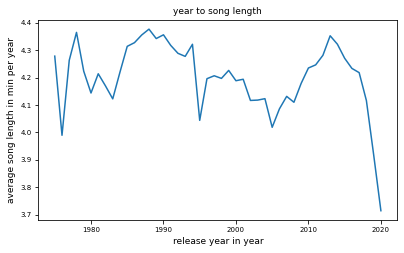

In [8]:
plt.plot(avg_songlength_per_year["year"], avg_songlength_per_year["duration_min"])
plt.title("year to song length")
plt.xlabel("release year in year")
plt.ylabel("average song length in min per year")
plt.show()

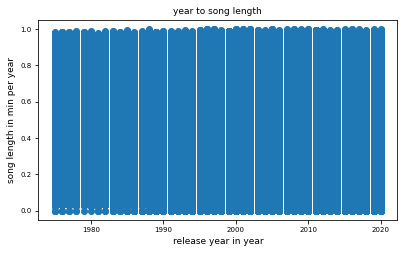

In [9]:
plt.scatter(duration_year_filtered["year"], duration_year_filtered["valence"])
plt.title("year to song length")
plt.xlabel("release year in year")
plt.ylabel("song length in min per year")
plt.show()

#### Average valence and release year in years:

In [10]:
valence_years = duration_year_filtered[['valence','year']].groupby('year', as_index=False).count()
total_valence_year = duration_year_filtered[['valence','year']].groupby('year', as_index=False).sum()
avg_valence_per_year = total_valence_year['valence']/valence_years['valence']
avg_valence_per_year = avg_valence_per_year.to_frame()
avg_valence_per_year.insert(loc=0, column='year', value=total_length_year['year'])

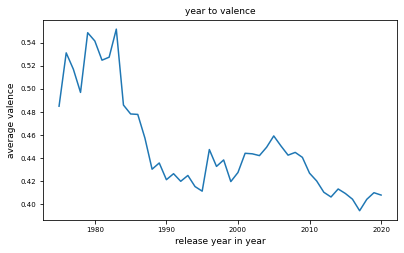

In [11]:
plt.plot(avg_valence_per_year["year"], avg_valence_per_year["valence"])
plt.title("year to valence")
plt.xlabel("release year in year")
plt.ylabel("average valence")
plt.rcParams['figure.figsize'] = 8, 8
plt.show()



## Hypothesis Testing:  

### Welch's unequal variances t-test to test the song length of 2 defined groups:


We would like to check if the average values before spotify became popular and after differed significantly.

group 1: All songs that were released before spotify existed (before 2008)  
group 2: All songs that were released when spotify existed (as of 2008)  

$\mu_1$ = mean of group 1  
$\mu_2$ = mean of group 2

Null hypothesis: There is no difference between the average song length of the individual groups.   
Alternative hypothesis: There is a difference between the average song length of the individual groups.  

More formal:  
$H_0: \mu_1 - \mu2 = 0$  
$H_1:\mu_1 - \mu_2 \neq 0$

For this we would like to do a t-test (2-sided) and compare the 2 means between the two different groups.  
With a level of significance $\alpha =$ 5%

In [12]:
duration_year_group1 = duration_year[duration_year['year'] < 2008]
duration_year_group2 = duration_year[duration_year['year'] >= 2008]

At the beginning we calculate the average value of the two groups.  
We make a distinction from 2008 onwards, as Spotify has existed since then.

In [13]:
songs_group1 = duration_year_group1[['name']].count()
songlength_group1 = duration_year_group1[['duration_min']].sum()
avg_group1 = songlength_group1['duration_min']/songs_group1['name']
avg_group1 = round(avg_group1,5)

songs_group2 = duration_year_group2[['name']].count()
songlength_group2 = duration_year_group2[['duration_min']].sum()
avg_group2 = songlength_group2['duration_min']/songs_group2['name']
avg_group2 = round(avg_group2,5)

In [14]:
print('avg group1:',avg_group1, '\navg group2:',avg_group2)

avg group1: 4.15115 
avg group2: 4.14422


As we can see here, our average values are very close to each other.  
Therefore, we now want to investigate whether there is a significant difference by using a t-test.  
We use scipy to peform a Welch's t-test.  
We used the formula from here: https://en.wikipedia.org/wiki/Welch%27s_t-test

In [15]:
from scipy.stats import ttest_ind_from_stats
from scipy.special import stdtr


g1 = duration_year_group1['duration_min']
g2 = duration_year_group2['duration_min']

# Compute the statistics for the t-test of group1 and group2 by hand:

gr1_mean = g1.mean()     # compute the mean of group 1
gr1_var = g1.var()       # compute the variance of group 1
gr1_n = g1.size          # get n of group 1
gr1_dof = gr1_n - 1      # get degreee of freedom of group 1

gr2_mean = g2.mean()     # compute the mean of group 2
gr2_var = g2.var()       # compute the variance of group 2
gr2_n = g2.size          # get n of group 2
gr2_dof = gr2_n - 1      # get degreee of freedom of group 2

# Use the formula directly.
t_value = (gr1_mean - gr2_mean) / np.sqrt(gr1_var/gr1_n + gr2_var/gr2_n)        # calculate t-value
dof_v = (gr1_var/gr1_n + gr2_var/gr2_n)**2 / (gr1_var**2/(gr1_n**2*gr1_dof) 
                                              + gr2_var**2/(gr2_n**2*gr2_dof))  # calculate degree of freedom v
p_value = 2*stdtr(dof_v, -np.abs(t_value))                                      # calculate p-value


# Use scipy.stats.ttest_ind_from_stats to check our calculations
t_scipy, p_scipy = ttest_ind_from_stats(gr1_mean, np.sqrt(gr1_var), gr1_n, gr2_mean, np.sqrt(gr2_var), gr2_n,equal_var=False)

# to get the critical t-value
t_crit = scipy.stats.t.ppf(0.05, dof_v)

print("calculated by hand: t = %g  p = %g" % (t_value, p_value))
print("calculated by ttest_ind_from_stats: t = %g  p = %g" % (t_scipy, p_scipy))
print("t_crit:", t_crit)


calculated by hand: t = 1.41317  p = 0.157607
calculated by ttest_ind_from_stats: t = 1.41317  p = 0.157607
t_crit: -1.644854906188107


##### The p-value obtained from the t-test is not significant (p is not less than 0.05), and therefore we conclude that the song length of group 1 and the song length of group 2 do not show a significant difference.

##### Thus, if the test statistics t-value is less than -1.6449 or greater than 1.6449, the results of the test are statistically significant and therefore we conclude that the song length of group 1 and the song length of group 2 do not show a significant difference.

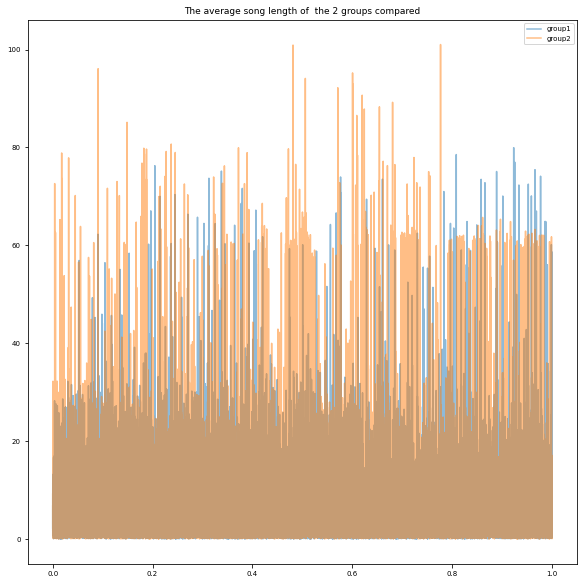

In [16]:
# plot the mean of the 2 groups
g1 = duration_year_group1['duration_min']
g2 = duration_year_group2['duration_min']
x1 = np.linspace(0, 1, len(g1))
x2 = np.linspace(0, 1, len(g2))

plt.plot(x1, g1, label = "group1", alpha=0.5)
plt.plot(x2, g2, label = "group2", alpha=0.5)
plt.title('The average song length of  the 2 groups compared')
plt.legend()
plt.show()

### Welch's unequal variances t-test to test the valence of 2 defined groups:
No we want to check the same thing but for the valence.


group 1: All songs that were released before 1985  
group 2: All songs that were released after 1985 (when we can see a difference in the plots)  
$\mu_1$ = mean of group 1  
$\mu_2$ = mean of group 2

Null hypothesis: There is no difference between the valence before 1985 and after 1985  
Alternative hypothesis: There is a difference between the valence before 1985 and after 1985  

More formal:  
$H_0: \mu_1 - \mu2 = 0$  
$H_1:\mu_1 - \mu_2 \neq 0$

For this we would like to do a t-test (2-sided) and compare the 2 means between the two different groups.  
With a level of significance $\alpha =$ 5%

In [17]:
valence_group1_filtered = duration_year[duration_year['year'] < 1985]
valence_group2_filtered = duration_year[duration_year['year'] >= 1985]

In [18]:
song_v_group1 = valence_group1_filtered[['name']].count()
valence_group1 = valence_group1_filtered[['valence']].sum()
avg_group1_v = valence_group1['valence']/song_v_group1['name']
avg_group1_v = round(avg_group1_v,5)

song_v_group2 = valence_group2_filtered[['name']].count()
valence_group2 = valence_group2_filtered[['valence']].sum()
avg_group2_v = valence_group2['valence']/song_v_group2['name']
avg_group2_v = round(avg_group2_v,5)

In [19]:
print('avg group1:',avg_group1_v, '\navg group2:',avg_group2_v)

avg group1: 0.4972 
avg group2: 0.42554


As we can see here, our average values are close to each other.  
Therefore, we now want to investigate whether there is a significant difference by using a t-test.  
We use scipy to peform a Welch's t-test.  
We used the formula from here: https://en.wikipedia.org/wiki/Welch%27s_t-test

In [20]:
from scipy.stats import ttest_ind_from_stats
from scipy.special import stdtr
import scipy.stats

g1 = valence_group1_filtered['valence']
g2 = valence_group2_filtered['valence']

# Compute the statistics for the t-test of group1 and group2 by hand:

gr1_mean = g1.mean()     # compute the mean of group 1
gr1_var = g1.var()       # compute the variance of group 1
gr1_n = g1.size          # get n of group 1
gr1_dof = gr1_n - 1      # get degreee of freedom of group 1

gr2_mean = g2.mean()     # compute the mean of group 2
gr2_var = g2.var()       # compute the variance of group 2
gr2_n = g2.size          # get n of group 2
gr2_dof = gr2_n - 1      # get degreee of freedom of group 2

# Use the formula directly.
t_value = (gr1_mean - gr2_mean) / np.sqrt(gr1_var/gr1_n + gr2_var/gr2_n)        # calculate t-value
dof_v = (gr1_var/gr1_n + gr2_var/gr2_n)**2 / (gr1_var**2/(gr1_n**2*gr1_dof) 
                                              + gr2_var**2/(gr2_n**2*gr2_dof))  # calculate degree of freedom v
p_value = 2*stdtr(dof_v, -np.abs(t_value))                                      # calculate p-value


# Use scipy.stats.ttest_ind_from_stats to check our calculations
t_scipy, p_scipy = ttest_ind_from_stats(gr1_mean, np.sqrt(gr1_var), gr1_n, gr2_mean, np.sqrt(gr2_var), gr2_n,equal_var=False)

# to get the critical t-value
t_crit_v = scipy.stats.t.ppf(0.05, dof_v)

print("calculated by hand: t = %g  p = %g" % (t_value, p_value))
print("calculated by ttest_ind_from_stats: t = %g  p = %g " % (t_scipy, p_scipy))
print("t_crit:", t_crit_v)


calculated by hand: t = 50.471  p = 0
calculated by ttest_ind_from_stats: t = 50.471  p = 0 
t_crit: -1.6448884132460067


##### The p-value obtained from the t-test is significant (p less than 0.05), and therefore we conclude that the valence of group 1 and the valence of group 2 show a significant difference.

##### If the test statistics t-value is less than -1.6449 or greater than 1.6449, the results of the test are statistically significant and therefore we conclude that the valence of group 1 and the valence of group 2 show a significant difference.

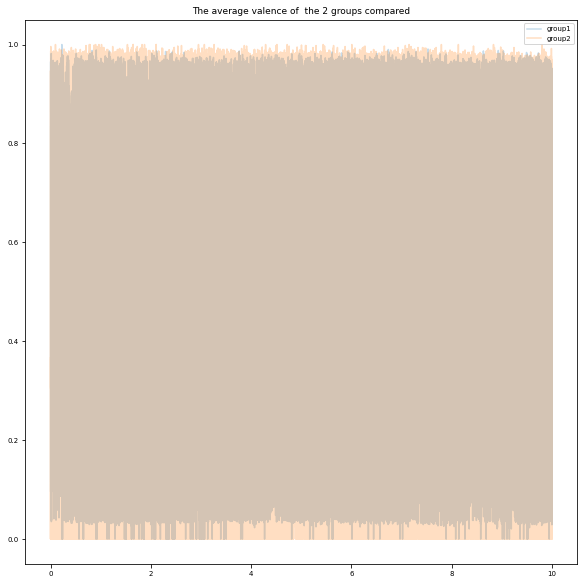

In [21]:
g1v = valence_group1_filtered['valence']
g2v = valence_group2_filtered['valence']
x1v = np.linspace(0, 10, len(g1))
x2v = np.linspace(0, 10, len(g2))

plt.plot(x1v, g1v, label = "group1", alpha=0.25)
plt.plot(x2v, g2v, label = "group2", alpha=0.25)
plt.title('The average valence of  the 2 groups compared')
plt.legend()
plt.show()

#### Some more hypothesis testing with different groups:

Some different groups:

group 1: All songs that were released before 2008  
group 2: All songs that were released after 2008  

$\mu_1$ = mean of group 1  
$\mu_2$ = mean of group 2

Null hypothesis: There is no difference between the valence before 2008 and after 2008  
Alternative hypothesis: There is a difference between the valence before 2008 and after 2008  

More formal:  
$H_0: \mu_1 - \mu2 = 0$  
$H_1:\mu_1 - \mu_2 \neq 0$

For this we would like to do a t-test (2-sided) and compare the 2 means between the two different groups.  
With a level of significance $\alpha =$ 5%

In [22]:
valence_group1_filtered1 = duration_year[duration_year['year'] < 2008]
valence_group2_filtered2 = duration_year[duration_year['year'] >= 2008]

In [23]:
song_v_group1 = valence_group1_filtered1[['name']].count()
valence_group1 = valence_group1_filtered1[['valence']].sum()
avg_group1_v = valence_group1['valence']/song_v_group1['name']
avg_group1_v = round(avg_group1_v,5)

song_v_group2 = valence_group2_filtered2[['name']].count()
valence_group2 = valence_group2_filtered2[['valence']].sum()
avg_group2_v = valence_group2['valence']/song_v_group2['name']
avg_group2_v = round(avg_group2_v,5)

In [24]:
print('avg group1:',avg_group1_v, '\navg group2:',avg_group2_v)

avg group1: 0.44473 
avg group2: 0.41437


As we can see here, our average values are close to each other.  
Therefore, we now want to investigate whether there is a significant difference by using a t-test.  
We use scipy to peform a Welch's t-test.  
We used the formula from here: https://en.wikipedia.org/wiki/Welch%27s_t-test

In [25]:
from scipy.stats import ttest_ind_from_stats
from scipy.special import stdtr
import scipy.stats

g1 = valence_group1_filtered1['valence']
g2 = valence_group2_filtered2['valence']

# Compute the statistics for the t-test of group1 and group2 by hand:

gr1_mean = g1.mean()     # compute the mean of group 1
gr1_var = g1.var()       # compute the variance of group 1
gr1_n = g1.size          # get n of group 1
gr1_dof = gr1_n - 1      # get degreee of freedom of group 1

gr2_mean = g2.mean()     # compute the mean of group 2
gr2_var = g2.var()       # compute the variance of group 2
gr2_n = g2.size          # get n of group 2
gr2_dof = gr2_n - 1      # get degreee of freedom of group 2

# Use the formula directly.
t_value = (gr1_mean - gr2_mean) / np.sqrt(gr1_var/gr1_n + gr2_var/gr2_n)        # calculate t-value
dof_v = (gr1_var/gr1_n + gr2_var/gr2_n)**2 / (gr1_var**2/(gr1_n**2*gr1_dof) 
                                              + gr2_var**2/(gr2_n**2*gr2_dof))  # calculate degree of freedom v
p_value = 2*stdtr(dof_v, -np.abs(t_value))                                      # calculate p-value


# Use scipy.stats.ttest_ind_from_stats to check our calculations
t_scipy, p_scipy = ttest_ind_from_stats(gr1_mean, np.sqrt(gr1_var), gr1_n, gr2_mean, np.sqrt(gr2_var), gr2_n,equal_var=False)

# to get the critical t-value
t_crit_v = scipy.stats.t.ppf(0.05, dof_v)

print("calculated by hand: t = %g  p = %g" % (t_value, p_value))
print("calculated by ttest_ind_from_stats: t = %g  p = %g " % (t_scipy, p_scipy))
print("t_crit:", t_crit_v)


calculated by hand: t = 61.0653  p = 0
calculated by ttest_ind_from_stats: t = 61.0653  p = 0 
t_crit: -1.6448549728854132


##### The p-value obtained from the t-test is significant (p less than 0.05), and therefore we conclude that the valence of group 1 and the valence of group 2 show a significant difference.

##### If the test statistics t value is less than -1.6449 or greater than 1.6449, the results of the test are statistically significant and therefore we conclude that the valence of group 1 and the valence of group 2 show a significant difference.